# Milestone 2 - CasierVert952

TODO : Ajouter un texte qui explique le but de notre projet


This data analysis will be conduct on two available datasets. The data come from two different beers rating websites :

- BeerAdvocate
- RateBeer

> *In the following: BeerAdvocate will be abbreviated as BA and RateBeer as RB.*

> *For improved readability, the complex and long functions developed for this analysis have been moved to ```helpers.py```. We import these functions into the relevant cells as needed.*

## 0. Initial configuration

### 0.1 Importation of libraries and golbal variable declarations

The ```USE_PREPROCESSED_DATA``` variable in the next cell should remain set to ```False``` during the first execution of this document. Afterward, you can set it to ```True``` to skip the time-consuming data preprocessing in subsequent runs.

In [1]:
# Import the basic requiered libraries
import os
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Path variables
BA_DATA_PATH = "data/BeerAdvocate/"
RB_DATA_PATH = "data/RateBeer/"

# General variable to precompute the data or not
USE_PREPROCESSED_DATA = False
COMPUTE_PREPROCESSED_DATA = not USE_PREPROCESSED_DATA

### 0.2 Transforming the ratings files from TXT to CSV and loading them

You can download the ```ratings.csv``` files for both dataset with the following links (~2GB each):

- For BA : [here](https://coursedingler.ch/data/BA/ratings.csv)
- For RB : [here](https://coursedingler.ch/data/RB/ratings.csv)

The following cell should **NOT** be executed, it only shows how the ```ratings.csv``` for each dataset were generated.

It take around 19 minutes to generate the BA ratings file and 14 minutes for the RB one.

```python
from helpers import txt_to_csv

file_txt = 'ratings.txt'
file_csv = 'ratings.csv'

txt_to_csv(BA_DATA_PATH + file_txt, BA_data_path + file_csv, "BA")
txt_to_csv(RB_DATA_PATH + file_txt, RB_data_path + file_csv, "RB")
```

**Make sure you have been placed or generated the ```ratings.csv``` files in the ```BeerAdvocate``` and ```RateBeer``` folder as well as all other data files when executing the following cell !**
```
data/
├── BeerAdvocate
│   ├── beers.csv
│   ├── breweries.csv
│   ├── users.csv
│   └── ratings.csv
│
└── RateBeer
    ├── beers.csv
    ├── breweries.csv
    ├── users.csv
    └── ratings.csv
```

## 1. Data Preprocessing

### 1.1 Loading CSV data
Let first import the data in CSV format for the two dataset, the users, the beers and the breweries.

In [8]:
# Create Dataframes for the BA dataset
BA_beers = pd.read_csv(BA_DATA_PATH + 'beers.csv')
BA_breweries = pd.read_csv(BA_DATA_PATH + 'breweries.csv')
BA_users = pd.read_csv(BA_DATA_PATH + 'users.csv')

# Create Dataframes for the RB dataset
RB_beers = pd.read_csv(RB_DATA_PATH + 'beers.csv')
RB_breweries = pd.read_csv(RB_DATA_PATH + 'breweries.csv')
RB_users = pd.read_csv(RB_DATA_PATH + 'users.csv')

In [3]:
if (COMPUTE_PREPROCESSED_DATA):
    # Create Dataframes for the BA ratings file
    s_time = time.time()
    BA_rating = pd.read_csv(BA_DATA_PATH + 'ratings.csv')
    e_time = time.time()
    print("Reading of BA ratings ended in " + str(e_time - s_time) + " seconds.")

    # Create Dataframes for the RB ratings file
    s_time = time.time()
    RB_rating = pd.read_csv(RB_DATA_PATH + 'ratings.csv')
    e_time = time.time()
    print("Reading of RB ratings ended in " + str(e_time - s_time) + " seconds.")

Reading of BA ratings ended in 41.28337740898132 seconds.
Reading of RB ratings ended in 44.15859866142273 seconds.


In [4]:
if (COMPUTE_PREPROCESSED_DATA):
    print("Size of BA ratings dataset : " + str(BA_rating.shape))
    print("Size of RB ratings dataset : " + str(RB_rating.shape))

Size of BA ratings dataset : (8392192, 17)
Size of RB ratings dataset : (7121361, 16)


The ratings datasets contains both more than 7 millions of user's ratings with respectively 17 and 16 features for the BA and RB datasets.

### 1.2 Merging data

#### 1.2.1 Dropping and renaming columns

We are dropping the columns that are not needed, some of them will be recovered during the merging phase. The columns are renamed to avoid colisions during the merges.

In [5]:
from helpers import ratings_dict

if (COMPUTE_PREPROCESSED_DATA):
    # Removing not needed columns
    BA_rating.drop(columns=["text", "review"], inplace=True)
    RB_rating.drop(columns=["text"], inplace=True)
    
    # Removing columns that will be recovered when merging
    BA_rating.drop(columns=["brewery_name", "style", "beer_name", "user_name", "abv"], inplace=True)
    RB_rating.drop(columns=["brewery_name", "style", "beer_name", "user_name", "abv"], inplace=True)
    
    # Renaming the columns as define by "ratings_dict"
    BA_rating.rename(columns=ratings_dict, inplace=True)
    RB_rating.rename(columns=ratings_dict, inplace=True)

#### 1.2.2 Merging with beers 's Data

In [9]:
from helpers import beers_dict

if (COMPUTE_PREPROCESSED_DATA):
    # Merging with the beers's data
    BA_merged = pd.merge(BA_rating, BA_beers, on=["beer_id", "brewery_id"], how="inner")
    RB_merged = pd.merge(RB_rating, RB_beers, on=["beer_id", "brewery_id"], how="inner")
    
    # Renaming the columns as define by "beers_dict"
    BA_merged.rename(columns=beers_dict, inplace=True)
    RB_merged.rename(columns=beers_dict, inplace=True)

#### 1.2.3 Merging with breweries's data

In [10]:
from helpers import breweries_dict

if (COMPUTE_PREPROCESSED_DATA):
    # Merging with the breweries's data
    BA_merged = pd.merge(BA_merged, BA_breweries, left_on="brewery_id", right_on="id", how="inner")
    RB_merged = pd.merge(RB_merged, RB_breweries, left_on="brewery_id", right_on="id", how="inner")
    
    # Dropping the duplicate columns
    BA_merged.drop(columns=["id", "name"], inplace=True)
    RB_merged.drop(columns=["id", "name"], inplace=True)
    
    # Renaming the columns as define by "breweries_dict"
    BA_merged.rename(columns=breweries_dict, inplace=True)
    RB_merged.rename(columns=breweries_dict, inplace=True)

#### 1.2.4 Merging with users's data

In [11]:
from helpers import users_dict

if (COMPUTE_PREPROCESSED_DATA):
    # Merging with the users's data
    BA_merged = pd.merge(BA_merged, BA_users, on=["user_id"], how="inner")
    RB_merged = pd.merge(RB_merged, RB_users, on=["user_id"], how="inner")
    
    # Renaming the columns as define by "users_dict"
    BA_merged.rename(columns=users_dict, inplace=True)
    RB_merged.rename(columns=users_dict, inplace=True)

### 1.3 Data cleaning

#### 1.3.1 Changing date format

The format of the date field was initialy the timestamp format, here we convert it in a human readable format. We only keep the month and the year as it's the only element we need for our analyses.

In [12]:
if (COMPUTE_PREPROCESSED_DATA):
    # Changing the format of the date of the two datasets to the format "Month-Year" (the format can easily be changed).
    BA_cleaned = BA_merged
    BA_cleaned["rating_date"] = pd.to_datetime(BA_cleaned["rating_date"], unit='s').dt.strftime("%m-%Y")
    
    RB_cleaned = RB_merged
    RB_cleaned["rating_date"] = pd.to_datetime(RB_cleaned["rating_date"], unit='s').dt.strftime("%m-%Y")

#### 1.3.2 Extracting the country and states

Since our analyses will focus on american states, we have to divide the user location field in ```country``` and ```state```. The state is filled with ```nan``` if not present.

In [13]:
if (COMPUTE_PREPROCESSED_DATA):
    # Spliting the "user_location" in country and state fields
    split_locations = BA_cleaned['user_location'].str.split(',', expand=True)
    BA_cleaned['user_country'] = split_locations[0].str.strip()
    BA_cleaned['user_state'] = split_locations[1].str.strip() if len(split_locations) > 1 else np.nan
    
    split_locations = RB_cleaned['user_location'].str.split(',', expand=True)
    RB_cleaned['user_country'] = split_locations[0].str.strip()
    RB_cleaned['user_state'] = split_locations[1].str.strip() if len(split_locations) > 1 else np.nan

We divide breweries location field too.

In [14]:
if (COMPUTE_PREPROCESSED_DATA):
    # Spliting the "breweries_location" in country and state fields
    split_locations = BA_cleaned['breweries_location'].str.split(',', expand=True)
    BA_cleaned['breweries_country'] = split_locations[0].str.strip()
    BA_cleaned['breweries_state'] = split_locations[1].str.strip() if len(split_locations) > 1 else np.nan
    
    split_locations = RB_cleaned['breweries_location'].str.split(',', expand=True)
    RB_cleaned['breweries_country'] = split_locations[0].str.strip()
    RB_cleaned['breweries_state'] = split_locations[1].str.strip() if len(split_locations) > 1 else np.nan

#### 1.3.3 Removing missing countries

Here we are removing the elements from the dataframes where the country is missing. It's choice we made since the location where ratings were made is a central point for our analysis goals.

In [15]:
if (COMPUTE_PREPROCESSED_DATA):
    # First we will see what part of the datasets doesn't have the country field filled
    BA_nan_location = BA_cleaned['user_country'].isna()
    print("BA: \n   " + str(BA_nan_location.sum()) + " missing country -> " + str(round(BA_nan_location.mean() * 100, 2)) + "%")
    
    RB_nan_location = RB_cleaned['user_country'].isna()
    print("RB: \n   " + str(RB_nan_location.sum()) + " missing country -> " + str(round(RB_nan_location.mean() * 100, 2)) + "%")

BA: 
   500223 missing country -> 5.96%
RB: 
   203670 missing country -> 2.86%


In [16]:
if (COMPUTE_PREPROCESSED_DATA):
    # Dropping the element with no country field
    BA_cleaned = BA_cleaned.dropna(subset=['user_country'])
    RB_cleaned = RB_cleaned.dropna(subset=['user_country'])

### 1.4 Data visualization

The following illustrates the structure of our data after preprocessing. In the future analysis, we will create derived DataFrames from ```BA_merged``` and ```RB_merged``` by copying them, then removing, modifying, and adding features to these copies as needed.

In [17]:
if (COMPUTE_PREPROCESSED_DATA):
    display(BA_cleaned.sample(13))

,beer_id,brewery_id,rating_date,user_id,rating_appearance,rating_aroma,rating_palate,rating_taste,rating_overall,rating,...,breweries_nbr_beers,user_nbr_ratings,user_nbr_reviews,user_name,user_join_date,user_location,user_country,user_state,breweries_country,breweries_state
7668594,74714,24018,04-2015,stew.699894,4.00,3.00,4.50,3.25,3.50,3.41,...,125,108,3,Stew,1.350727e+09,"United States, Texas",United States,Texas,United States,Texas
4272764,100443,30654,04-2016,lateralundertow.736769,4.50,4.50,4.50,4.50,4.50,4.50,...,174,435,15,lateralundertow,1.371031e+09,"United States, New Jersey",United States,New Jersey,United States,Massachusetts
5087568,79835,96,06-2013,theruss9585.663258,NaN,NaN,NaN,NaN,NaN,2.50,...,139,659,0,TheRuss9585,1.331032e+09,"United States, Vermont",United States,Vermont,United States,Vermont
2603101,82083,140,08-2012,57md.617300,4.00,3.50,4.00,4.50,4.00,4.08,...,574,1741,1723,57md,1.314007e+09,"United States, Pennsylvania",United States,Pennsylvania,United States,California
5890898,1260,423,07-2012,punkyg0608.646383,NaN,NaN,NaN,NaN,NaN,3.50,...,140,87,0,Punkyg0608,1.324811e+09,"United States, Missouri",United States,Missouri,United States,Missouri
1564568,163263,22511,06-2015,mportnoy.684622,4.75,4.75,4.75,4.75,4.75,4.75,...,222,2102,22,mportnoy,1.342087e+09,"United States, Pennsylvania",United States,Pennsylvania,United States,Vermont
7631840,16811,464,05-2016,thatmanphil.1149762,3.75,5.00,4.25,4.00,4.00,4.25,...,8,42,7,thatmanphil,1.464430e+09,Germany,Germany,None,Germany,None
7537060,39687,5337,11-2011,rhino54.324118,NaN,NaN,NaN,NaN,NaN,4.00,...,44,290,0,rhino54,1.240654e+09,"United States, California",United States,California,United States,California
6003590,215299,73,05-2016,bobtaylor0414.1042137,4.25,3.75,3.75,4.25,4.00,4.03,...,171,124,0,bobtaylor0414,1.442138e+09,"United States, Pennsylvania",United States,Pennsylvania,United States,Ohio
3325903,108,35,07-2007,ndekke39.13679,4.50,4.00,4.00,4.00,4.50,4.13,...,285,328,328,ndekke39,1.106651e+09,"United States, Ohio",United States,Ohio,United States,Massachusetts


### 1.5 Saving cleaned data

The following cell will save the data merged and cleaned in CSV file. After that step, the two dataframes can be loaded quickly without performing the preprocessing step again and again.

In [18]:
if (COMPUTE_PREPROCESSED_DATA):
    # Saving the cleaned data in CSV files
    BA_cleaned.to_csv(BA_DATA_PATH + 'BA_cleaned.csv', index=False)
    RB_cleaned.to_csv(RB_DATA_PATH + 'RB_cleaned.csv', index=False)

If the processing step has aleady be done in a previous execution, we can just load directly the cleaned data from the CSV files.

In [19]:
if (USE_PREPROCESSED_DATA):
    # Laoding preprocessed data
    BA_cleaned = pd.read_csv(BA_DATA_PATH + 'BA_cleaned.csv', low_memory=False)
    RB_cleaned = pd.read_csv(RB_DATA_PATH + 'RB_cleaned.csv', low_memory=False)

## 2 Data exploration of both datasets

Indeed, we are given two different but very similar datasets to perform our analysis. Let's begin by examining them to determine the best approach: using one dataset, combining both, or creating a blend of the two.

### 2.1 Sizes

We will firstly interrest ourself to their size

In [20]:
# Printing the sizes of each Dataframe for both datasets.
print("BA :")
print("   Number of ratings   : " + str(BA_cleaned.shape[0]))
print("   Number of beers     : " + str(BA_beers.shape[0]))
print("   Number of breweries : " + str(BA_breweries.shape[0]))
print("   Number of users     : " + str(BA_users.shape[0]))
print("\nRB :")
print("   Number of ratings   : " + str(RB_cleaned.shape[0]))
print("   Number of beers     : " + str(RB_beers.shape[0]))
print("   Number of breweries : " + str(RB_breweries.shape[0]))
print("   Number of users     : " + str(RB_users.shape[0]))

BA :
   Number of ratings   : 7891969
   Number of beers     : 280823
   Number of breweries : 16758
   Number of users     : 153704

RB :
   Number of ratings   : 6919400
   Number of beers     : 442081
   Number of breweries : 24189
   Number of users     : 70174


The RB dataset contains more data on different beers and breweries, but less users than the BA one. Both datasets have more than 7 millions of user's ratings, which seems enough to perfom our analysis.

### 2.2 Country Representation

As our study will mainly focus on specific countries (the USA and European ones), we investigate the representation of countries in both datasets. This will assist us in selecting the most appropriate dataset for our final analyses.

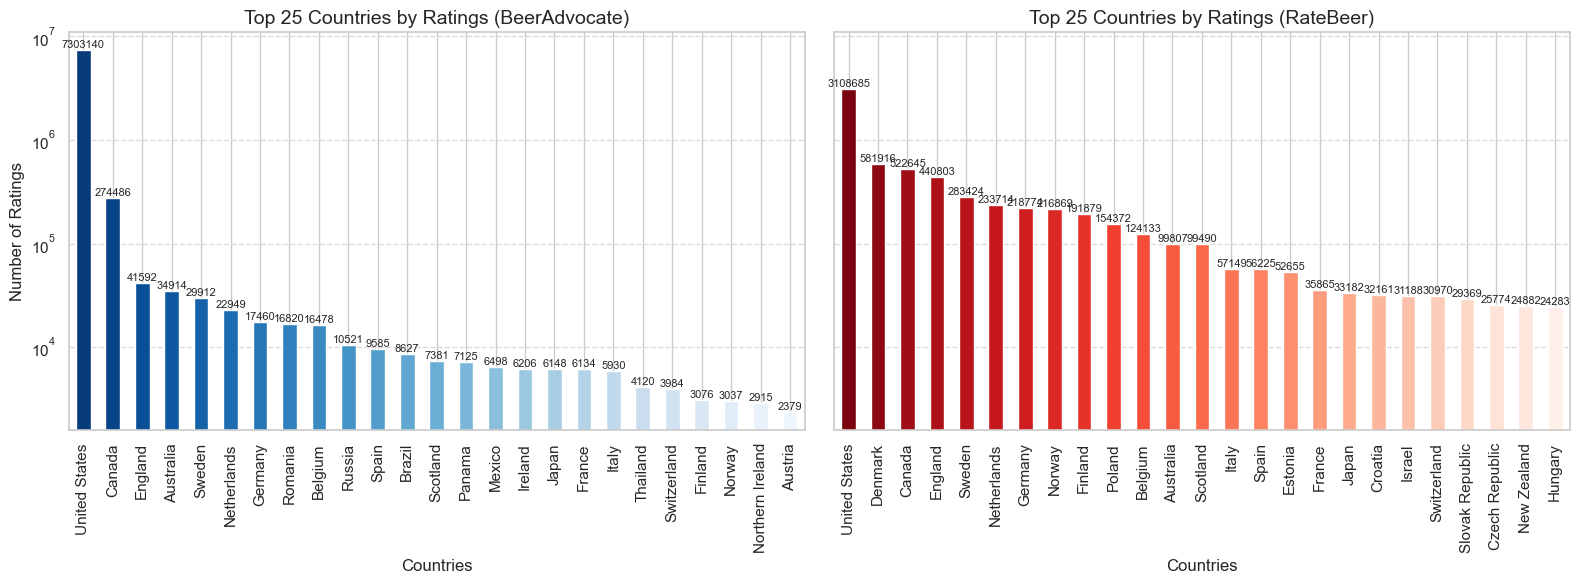

In [21]:
from helpers import ploting_country_representation

# Calculer le nombre de ratings par pays pour chaque DataFrame
BA_count_per_country = BA_cleaned.groupby('user_country').size().nlargest(25)
RB_count_per_country = RB_cleaned.groupby('user_country').size().nlargest(25)

ploting_country_representation(BA_count_per_country, RB_count_per_country, 'log')

In [22]:
# Country ratings with precise values
country_comparison = pd.DataFrame({
    'Country (BA)': BA_count_per_country.index,
    '# of Ratings (BeerAdvocate)': BA_count_per_country.values,
    '% of Ratings (BeerAdvocate)': np.round(BA_count_per_country.values / len(BA_cleaned) * 100, 2),
    'Country (RB)': RB_count_per_country.index,
    '# of Ratings (RateBeer)': RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values,
    '% of Ratings (RateBeer)': np.round(RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values / len(RB_cleaned) * 100, 2)
})
country_comparison.index = range(1, len(country_comparison) + 1)
country_comparison.head(10)

,Country (BA),# of Ratings (BeerAdvocate),% of Ratings (BeerAdvocate),Country (RB),# of Ratings (RateBeer),% of Ratings (RateBeer)
1,United States,7303140,92.54,United States,3108685,44.93
2,Canada,274486,3.48,Denmark,581916,8.41
3,England,41592,0.53,Canada,522645,7.55
4,Australia,34914,0.44,England,440803,6.37
5,Sweden,29912,0.38,Sweden,283424,4.10
6,Netherlands,22949,0.29,Netherlands,233714,3.38
7,Germany,17460,0.22,Germany,218774,3.16
8,Romania,16820,0.21,Norway,216869,3.13
9,Belgium,16478,0.21,Finland,191879,2.77
10,Russia,10521,0.13,Poland,154372,2.23


As evident from the plots and tables above, the BA dataset mainly consists of ratings from the US (92.5%), while the RB dataset contains a more balanced distribution, with approximately half of the ratings originating from the US and the other half from European countries.

Based on these results, it would be adequate to utilize the BA dataset for our analyses focused on the US, while the RB dataset would be more suitable for our analyses concerning Europe.

### 2.3 Ratings distribution over users

It is interessant to expolore the quantity of ratings that each user has published. Do we give more importance to regular users than to occasional ones ? Are users who have thousands and thousands of ratings relevant ? Areotheses usersbiasingt our result s?

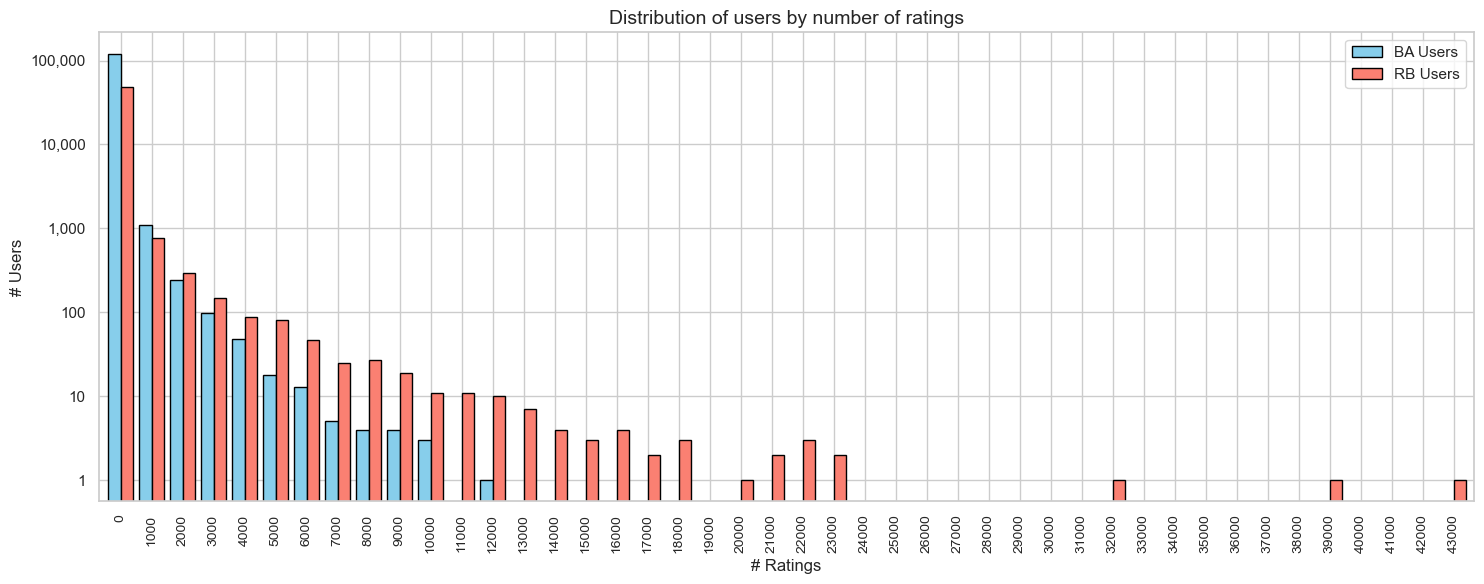

In [23]:
from helpers import ploting_user_ratings_distribution

# Computing the #ratings by users, and grouping them in bins of size 1000
BA_ratings_by_user = BA_cleaned.groupby('user_id').size().reset_index(name='#ratings')
BA_ratings_bins = pd.cut(BA_ratings_by_user['#ratings'], bins=np.arange(0, BA_ratings_by_user['#ratings'].max() + 1000, 1000))
BA_ratings_bins = BA_ratings_bins.value_counts().sort_index()

RB_ratings_by_user = RB_cleaned.groupby('user_id').size().reset_index(name='#ratings')
RB_ratings_bins = pd.cut(RB_ratings_by_user['#ratings'], bins=np.arange(0, RB_ratings_by_user['#ratings'].max() + 1000, 1000))
RB_ratings_bins = RB_ratings_bins.value_counts().sort_index()

# Only show the minial value of the bins in the graph
BA_ratings_bins.index = [f'{int(bin.left)}' for bin in BA_ratings_bins.index]
RB_ratings_bins.index = [f'{int(bin.left)}' for bin in RB_ratings_bins.index]

# Ploting the #ratings by users data
ploting_user_ratings_distribution(BA_ratings_bins, RB_ratings_bins)

#### TODO the ratings by user analyse

We say that ...

### 2.4 Ratings distribution over months

In our analyses, we will compare political properties with beer properties over time. It is important to examine the distribution of ratings across different months to ensure the relevance and validity of our results.

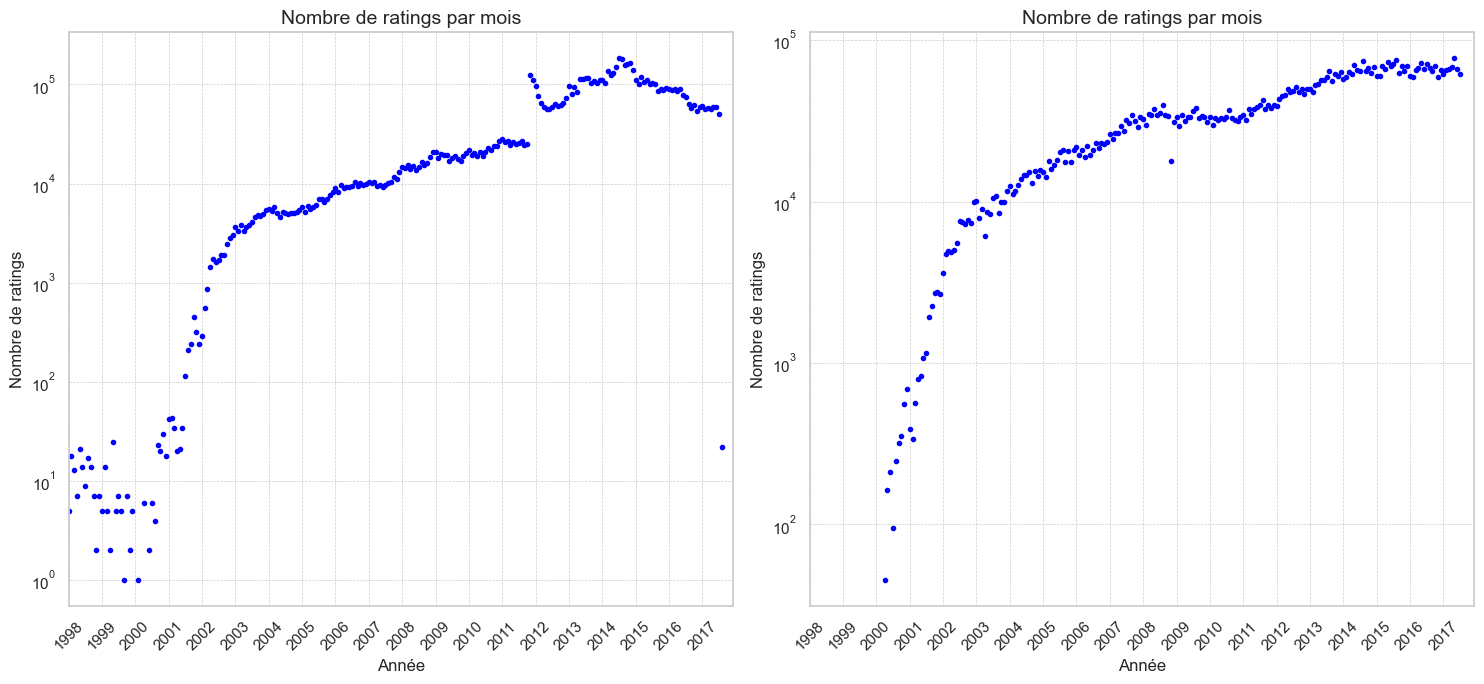

In [24]:
from helpers import ploting_ratings_by_month

# Computing the #ratings by month
BA_ratings_by_month = BA_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
BA_ratings_by_month['rating_date'] = pd.to_datetime(BA_ratings_by_month['rating_date'], format='%m-%Y')

RB_ratings_by_month = RB_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
RB_ratings_by_month['rating_date'] = pd.to_datetime(RB_ratings_by_month['rating_date'], format='%m-%Y')

# Ploting the #ratings by months data
ploting_ratings_by_month(BA_ratings_by_month, RB_ratings_by_month, "log")

For BeerAdvocate :

Before 2002, the number of user ratings each month is very low (under 1000), which may pose problems for conducting a reliable statistical analysis. On the contrary, starting from 2007, there are more than 10,000 ratings per month, providing a solid foundation for more precise analyses. It can also be noted that starting from 2012, the data shows significant volatility, with the number of ratings varying greatly from one month to the next one.

For RateBeer :

Before 2003, there is limited data, but after that year, the graph shows a consistent increase of data every month. This suggests that we can have more confidence in our results for the later years.

### 2.4 Conclusion on data exploration

Now that we have observed the two datasets in details, ...

#### TODO : Finir le text ici pour résumer l'exploration des données et nos choix pour la suite

## 3. Data refinement (to discuss)

#### TODO

Discuter si on prefere suprimmer certaine données en lien avec la data exporation avant de comencer les analyses.

## 4. External dataset used

## 5. Analysis : Relation Beer vs Political

Partie de Samuel pour creer un dataframe pour les USA et commencer les analyses.

In [36]:
#Create Dataframe of only USA users
RB_usa = RB_merged.copy()[RB_merged['user_country'].str.contains('United States', case=False, na=False)]
BA_usa = BA_merged.copy()[BA_merged['user_country'].str.contains('United States', case=False, na=False)]
RB_usa.columns

Index(['beer_id', 'brewery_id', 'rating_date', 'user_id', 'rating_appearance',
       'rating_aroma', 'rating_palate', 'rating_taste', 'rating_overall',
       'rating', 'beer_name', 'brewery_name', 'beer_style', 'beer_nbr_ratings',
       'overall_score', 'style_score', 'beer_avg', 'beer_abv',
       'beer_avg_computed', 'beer_zscore', 'beer_nbr_matched_valid_ratings',
       'beer_avg_matched_valid_ratings', 'breweries_location',
       'breweries_nbr_beers', 'user_nbr_ratings', 'user_name',
       'user_join_date', 'user_location', 'user_country', 'user_state',
       'breweries_country', 'breweries_state'],
      dtype='object')

In [39]:
RB_usa[['beer_id', 'brewery_id', 'rating_date', 'user_id', 'rating_appearance',
       'rating_aroma', 'rating_palate', 'rating_taste', 'rating_overall',
       'rating', 'beer_name', 'brewery_name', 'beer_style', 'beer_nbr_ratings',
       'overall_score', 'style_score', 'beer_avg', 'beer_abv',
       'beer_avg_computed', 'beer_zscore', 'beer_nbr_matched_valid_ratings',
       'beer_avg_matched_valid_ratings', 'breweries_location',
       'breweries_nbr_beers', 'user_nbr_ratings', 'user_name',
       'user_join_date', 'user_location', 'user_country', 'user_state',
       'breweries_country', 'breweries_state']].sample(10)

,beer_id,brewery_id,rating_date,user_id,rating_appearance,rating_aroma,rating_palate,rating_taste,rating_overall,rating,...,breweries_location,breweries_nbr_beers,user_nbr_ratings,user_name,user_join_date,user_location,user_country,user_state,breweries_country,breweries_state
6714803,171735,1926,12-2012,103103,4,8,4,8,15,3.9,...,"United States, Colorado",245,72,TronnyJenkins,1.268305e+09,"United States, Texas",United States,Texas,United States,Colorado
6749461,531,90,03-2007,49621,4,7,4,8,16,3.9,...,"United States, New York",179,31,BrendanC,1.171105e+09,"United States, New York",United States,New York,United States,New York
6480065,56242,5606,08-2010,99545,5,8,5,9,18,4.5,...,"United States, Pennsylvania",137,1522,cpetrone84,1.262344e+09,"United States, Pennsylvania",United States,Pennsylvania,United States,Pennsylvania
2053081,407577,26651,05-2017,5332,4,5,4,5,10,2.8,...,"United States, Utah",16,6236,Braudog,1.028714e+09,"United States, Virginia",United States,Virginia,United States,Utah
2112584,47416,12853,01-2008,5931,4,7,3,7,14,3.5,...,"United States, Illinois",263,5754,jgb9348,1.036062e+09,"United States, Virginia",United States,Virginia,United States,Illinois
4737769,4729,11,06-2004,6785,2,3,2,2,4,1.3,...,"United States, California",51,2227,robertsreality,1.044270e+09,"United States, Minnesota",United States,Minnesota,United States,California
7117951,835,132,04-2014,311897,5,2,5,3,7,2.2,...,Belgium,2,2,bgunn83,1.396951e+09,"United States, Georgia",United States,Georgia,Belgium,None
6110279,548,92,04-2008,47801,3,6,3,6,15,3.3,...,"United States, New York",208,100,psuCE03,1.168340e+09,"United States, Pennsylvania",United States,Pennsylvania,United States,New York
3697738,471123,14670,07-2017,88036,4,8,4,8,15,3.9,...,"United States, California",46,10139,slowrunner77,1.235732e+09,"United States, Nevada",United States,Nevada,United States,California
5191321,68574,84,11-2013,166318,1,1,2,5,9,1.8,...,"United States, Missouri",216,620,kdm1984,1.332929e+09,"United States, Missouri",United States,Missouri,United States,Missouri


In [26]:
#Df of the other countries
RB_other = RB_merged.copy()[~RB_merged['user_country'].str.contains('United States', case=False, na=True)]
BA_other = BA_merged.copy()[~BA_merged['user_country'].str.contains('United States', case=False, na=True)]

In [ ]:
#Top ten beer styles for users of different states for RB

#Democrats States
RB_california = RB_usa.copy()[RB_usa['user_state']=='California']

# Keep the beer if it has at leat 10 ratings
counts = RB_california.groupby('beer_id')['rating'].transform('count')
RB_california = RB_california[counts >= 10]
top10_california = RB_california[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_massachusetts = RB_usa.copy()[RB_usa['user_state']=='Massachusetts']
counts = RB_massachusetts.groupby('beer_id')['rating'].transform('count')
RB_massachusetts = RB_massachusetts[counts >= 10]
top10_massachusetts =RB_massachusetts[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

#Republican States
RB_alabama = RB_usa.copy()[RB_usa['user_state']=='Alabama']
counts = RB_alabama.groupby('beer_id')['rating'].transform('count')
RB_alabama = RB_alabama[counts >= 10]
top10_alabama =RB_alabama[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_indiana = RB_usa.copy()[RB_usa['user_state']=='Indiana']
counts = RB_indiana.groupby('beer_id')['rating'].transform('count')
RB_indiana = RB_indiana[counts >= 10]
top10_indiana =RB_indiana[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_wyoming = RB_usa.copy()[RB_usa['user_state']=='Wyoming']
counts = RB_wyoming.groupby('beer_id')['rating'].transform('count')
RB_wyoming = RB_wyoming[counts >= 5]
top10_wyoming =RB_wyoming[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)


In [28]:

df_top_5_beer_style = pd.DataFrame({
    'Top 5':np.arange(1,6),
    'California':top10_california.index[:5],
    'Massachusetts': top10_massachusetts.index[:5],
    'Alabama': top10_alabama.index[:5],
    'Indiana': top10_indiana.index[:5],
    'Wyoming': top10_wyoming.index[:5],
})
df_top_5_beer_style

,Top 5,California,Massachusetts,Alabama,Indiana,Wyoming
0,1,Abt/Quadrupel,Abt/Quadrupel,Traditional Ale,Abt/Quadrupel,Foreign Stout
1,2,Lambic Style - Gueuze,Lambic Style - Gueuze,Weizen Bock,Imperial Stout,Brown Ale
2,3,Imperial Stout,Sour/Wild Ale,Abt/Quadrupel,Weizen Bock,Dry Stout
3,4,Sour/Wild Ale,Sour Red/Brown,Imperial Stout,Eisbock,Altbier
4,5,Sour Red/Brown,Imperial Stout,Lambic Style - Gueuze,Sour Red/Brown,Imperial IPA


In [30]:
#Top ten beer for users of different states for RB

#Democrats States
RB_california = RB_usa.copy()[RB_usa['user_state']=='California']

# Keep the beer if it has at leat 10 ratings
counts = RB_california.groupby('beer_id')['rating'].transform('count')
RB_california = RB_california[counts >= 10]
top10_california = RB_california[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_massachusetts = RB_usa.copy()[RB_usa['user_state']=='Massachusetts']
counts = RB_massachusetts.groupby('beer_id')['rating'].transform('count')
RB_massachusetts = RB_massachusetts[counts >= 10]
top10_massachusetts =RB_massachusetts[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

#Republican States
RB_alabama = RB_usa.copy()[RB_usa['user_state']=='Alabama']
counts = RB_alabama.groupby('beer_id')['rating'].transform('count')
RB_alabama = RB_alabama[counts >= 10]
top10_alabama =RB_alabama[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_indiana = RB_usa.copy()[RB_usa['user_state']=='Indiana']
counts = RB_indiana.groupby('beer_id')['rating'].transform('count')
RB_indiana = RB_indiana[counts >= 10]
top10_indiana =RB_indiana[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_wyoming = RB_usa.copy()[RB_usa['user_state']=='Wyoming']
counts = RB_wyoming.groupby('beer_id')['rating'].transform('count')
RB_wyoming = RB_wyoming[counts >= 5]
top10_wyoming =RB_wyoming[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)


In [35]:
top10_alabama

rating        \
                                                  mean count   
beer_name                                                      
Westvleteren 12 (XII)                         4.538889    18   
Rochefort Trappistes 10                       4.367742    31   
Westvleteren Extra 8                          4.318182    11   
Russian River Pliny the Elder                 4.295238    21   
Girardin Gueuze Black Label                   4.280000    10   
AleSmith Speedway Stout                       4.261111    18   
Great Divide Yeti Imperial Stout - Oak Aged   4.259091    22   
North Coast Old Rasputin (Bourbon Barrel)     4.245455    11   
Hoppin Frog BORIS The Crusher                4.220000    10   
Rogue Imperial Stout                          4.215385    13   

                                                     breweries_location  
                                                                  first  
beer_name                                                                
Westvleteren 12 (XII)                                           Belgium  
Rochefort Trappistes 10                                         Belgium  
Westvleteren Extra 8                                            Belgium  
Russian River Pliny the Elder                 United States, California  
Girardin Gueuze Black Label                                     Belgium  
AleSmith Speedway Stout                       United States, California  
Great Divide Yeti Imperial Stout - Oak Aged     United States, Colorado  
North Coast Old Rasputin (Bourbon Barrel)     United States, California  
Hoppin Frog BORIS The Crusher                      United States, Ohio  
Rogue Imperial Stout                              United States, Oregon

In [ ]:
#QUESTIONS :
# 1 : Quels styles de bière les états préfèrent? (selon parti) SAMUEL
# 1.2 : Pourcentage d'alcool ?

# 2 : Quels états préfèrent consommer local(etat-national?,national-international?)DANIEL

# EN DESSOUS, Cellules de tests, à retirer !!!

In [ ]:
with open('data/BeerAdvocate/ratings.txt', 'r') as fichier:
    for i, ligne in enumerate(fichier):
        if i >= 100000:  # Arrête la boucle après 100 lignes
            break
        print(ligne.strip())

In [41]:
from importlib import reload
import helpers
reload(helpers)

<module 'helpers' from 'C:\\Users\\Fabian Roulin\\Desktop\\git\\ada-2024-project-casiervert952\\helpers.py'>